In [1]:
import os
from glob import glob
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import mne
mne.set_log_level(verbose=False)
import wandb
from tqdm.auto import tqdm

from Datasets import *

C:\Users\vila_\anaconda3\envs\Master\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vila_\anaconda3\envs\Master\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\vila_\anaconda3\envs\Master\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
config = {
    'epochs':10,
    'classes':5,
    'batch_size':32,
    'learning_rate':3e-4,
    'channels':['F4'],
    'patients_train':1,
    'patients_test':2,
    'binary':False,
    'metadata': "Test Normalización en memoria"
}

## Testing with simple models

In [3]:
import tensorflow as tf

In [4]:
sampling_rate = 512

In [5]:
def create_simple_model(sampling_rate, classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(128, kernel_size=sampling_rate//2, strides=sampling_rate//4, activation="relu", input_shape=(15360,1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
def load_data(path):
    dataset = EDFData(path=path, channels=config["channels"], binary=False)
    data = dataset.epochs.get_data()
    data = np.squeeze(data, axis=1)
    labels = dataset.epochs.events[:,-1]

    return data, labels

In [7]:
def create_scaled_data(data):
    ## Obtain mean and std
    mean = data.mean()
    std = data.std()

    ## Create different data
    data_std = (data - mean)/std
    data_norm = data / np.expand_dims(np.abs(data).max(axis=1),-1)
    data_norm_std = (data_norm - data_norm.mean())/data_norm.std()
    data_norm_nomean = (data_norm - np.expand_dims(data_norm.mean(axis=1),-1))

    ## Put them into a dictionary so its more clean
    scaled_data = {
        "Raw Data":data,
        "Standarized Data":data_std,
        "Normalized Data":data_norm,
        "Normalized and Standarized Data":data_norm_std,
        "Normalized and Mean Substracted Data":data_norm_nomean
    }

    return scaled_data
    

In [8]:
def train_scaled_data(scaled_data, labels, epochs=50):
    histories = {}

    ## Train a model for each different scaled data and store the History object
    for name, data in tqdm(scaled_data.items()):
        model = create_simple_model(512, config["classes"])
        history = model.fit(np.expand_dims(data, axis=-1), labels, batch_size=16, epochs=epochs, verbose=0)
        histories[name] = history
    
    return histories

In [9]:
def plot_histories(histories, n_patients):    
    plt.figure(figsize=(16,6))
    plt.suptitle(f"{n_patients} Patients")
    plt.subplot(1,2,1)
    plt.title("Loss")

    for i, (name, history) in enumerate(histories.items()):
        plt.plot(history.history["loss"], label=name)

    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Accuracy")

    for i, (name, history) in enumerate(histories.items()):
        plt.plot(history.history["accuracy"], label=name)

    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.show()

100%|██████████| 5/5 [00:37<00:00,  7.43s/it]


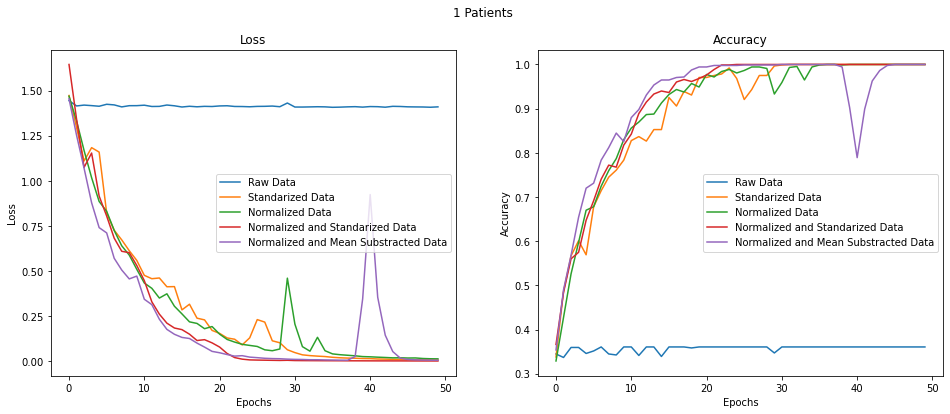

100%|██████████| 5/5 [00:51<00:00, 10.26s/it]


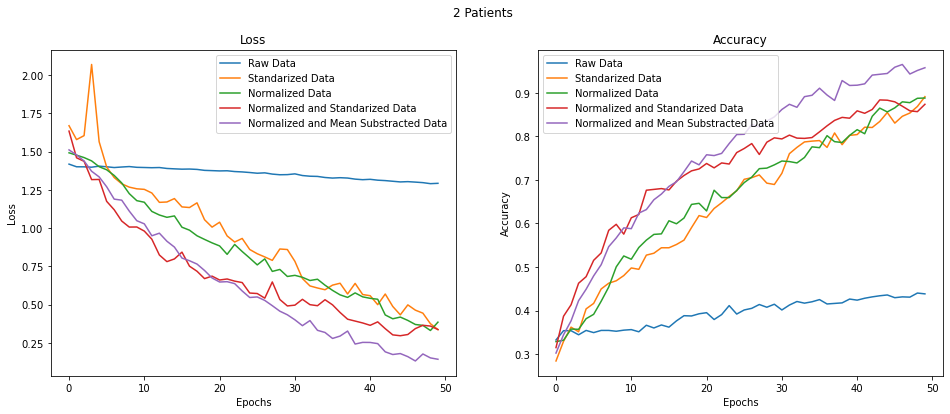

In [10]:
patients = []
for i, path in enumerate(glob("../Data/*.edf"), 1):
    
    if i > 1: # If it's not the first iteration
        ## Obtain new data
        data, labels_new = load_data(path)
        scaled_data_new = create_scaled_data(data)
        ## Concat new data to last data
        scaled_data = {key:np.concatenate([value, scaled_data_new[key]]) for key, value in scaled_data.items()}
        labels = np.concatenate([labels, labels_new])

    else:
        data, labels = load_data(path)
        scaled_data = create_scaled_data(data)

    histories = train_scaled_data(scaled_data, labels-1, epochs=50) # Very important -1 so that labels are [0,4] and not [1,5]
    plot_histories(histories, n_patients=i)

    # if i == 2:
    #     break